# **Gradient echoes and SSFP exercises 2: DESS - solution**

In this exercise, you will change a standard 3D gradient echo scan (FISP) into a DESS sequence.

Optionally, go also for the TESS sequence (triple echo steady state, see
Sobol and Gauntt,JMRI 6:384-398(1996),Fig.11)

# Exercises

Starting point is the unbalanced gradient echo sequence (FISP).

## 2.1 DESS
Modify FISP to obtain a DESS sequence. Introduce a second ADC (with echo (ECO) labeling) and modify the readout gradient accordingly. To see different contrast for the two echoes, you might use a lower flip angle.

## 2.2 TESS (optional)
Modify DESS to obtain a TESS sequence. Introduce a third ADC (with echo (ECO) labeling) and modify the readout gradient further. Hint: you must also modify the gradient area A of gx_pre.

# Initialization

In [ ]:
import importlib
if importlib.util.find_spec('pypulseq') is None:
    !pip install -q mrzerocore git+https://github.com/imr-framework/pypulseq.git

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

import pypulseq as pp

!wget -nc https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py
from utils import animate, simulate_2d, recon_cartesian_3d, plot_nd

File ‘utils.py’ already there; not retrieving.



# **Create, simulate, and reconstruct sequence**

**GRE Sequence definition**

Timing check passed successfully


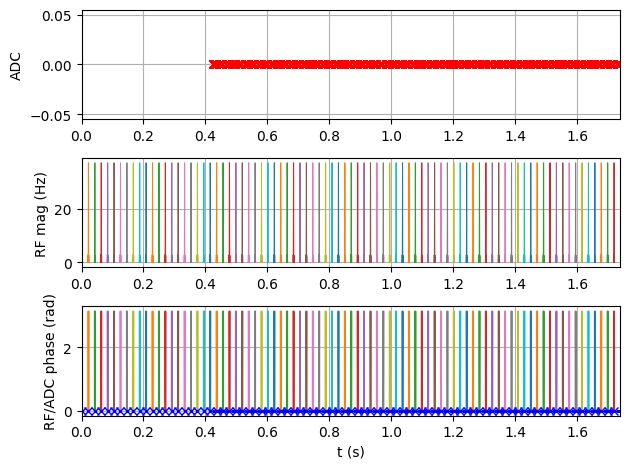

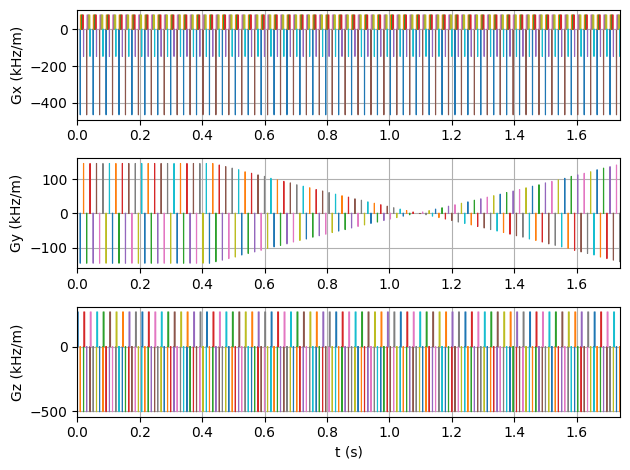

Number of blocks: 588
Number of events:
RF:     84
Gx:    420
Gy:    168
Gz:    252
ADC:    192
Delay:      0
Sequence duration: 1.738800 s
TE: 0.013240 s
TR: 0.020700 s
Flip angle: 10.00 deg
Unique k-space positions (aka cols, rows, etc.): 192 64 
Dimensions: 2
Spatial resolution: 1.33 mm
Spatial resolution: 4.00 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Event timing check passed successfully
Max gradient: 465856 145349 502058 Hz/m == 10.94 3.41 11.79 mT/m
Max slew rate: 3906250000 1038205980 5333333333 Hz/m/s == 91.75 24.38 125.27 T/m/s
Max absolute gradient: 700150 Hz/m == 16.44 mT/m
Max absolute slew rate: 5.33332e+09 Hz/m/s == 125.27 T/m/s


In [ ]:
plot = True
write_seq = True
seq_filename = "gre_3d.seq"

# ======
# SETUP
# ======

# Define FOV and resolution
fov = [256e-3, 256e-3, 5e-3]
Nx = 64
Ny = 64
Nz = 1
alpha = 10  # flip angle - for DESS and TESS, cahnge it to, e.g., 10 deg.
TR = 20e-3  # Repetition time
TE = 10e-3  # Echo time
dummy_scans = 100 # Number of dummy repetitions

ro_os = 1 # Readout oversampling

# Here are the modfications in the gradient schemes needed tu fulfil the exercises. For further changes that are needed, see the comments in the sequence block.
# FISP
#A = -0.5
#C = 0.5
#rf_inc = 0

# DESS
#A = -0.5
#C = -0.5
#rf_inc = 0

# TESS
A = -1.5
C = -0.5
rf_inc = 0


readout_duration = 3.2e-3 # Readout duration (sec)
pe_duration = 1e-3 # Duration of phase encoding gradients (sec)

# Create system object
system = pp.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=150,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

# Create a new sequence object
seq = pp.Sequence(system=system)

# ======
# CREATE EVENTS
# ======
rf, gz, _ = pp.make_sinc_pulse(
    flip_angle=alpha * math.pi / 180,
    duration=3e-3,
    slice_thickness=fov[2],
    apodization=0.42,
    time_bw_product=4,
    system=system,
    return_gz=True
)

# Define other gradients and ADC events
delta_kx = 1 / fov[0]
delta_ky = 1 / fov[1]
delta_kz = 1 / fov[2]

gx = pp.make_trapezoid(channel="x", flat_area=Nx * delta_kx, flat_time=readout_duration, system=system)
adc = pp.make_adc(num_samples=Nx * ro_os, duration=gx.flat_time, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel="x", area=-gx.area / 2, duration=pe_duration, system=system)

gx_spoil = pp.make_trapezoid(channel="x", area=2 * Nx * delta_kx, system=system)
gz_spoil = pp.make_trapezoid(channel="z", area=4 / fov[2], system=system)

# Phase encoding
phase_areas_y = (np.arange(Ny) - Ny // 2) * delta_ky
phase_areas_z = (np.arange(Nz) - Nz // 2) * delta_kz

# Phase encoding table with YZ order (outer loop = Z, inner loop = Y)
phase_encode_table = [(y,z) for z in range(len(phase_areas_z)) for y in range(len(phase_areas_y))]

# Calculate timing
delay_TE = (
    np.ceil(
        (
            TE
            - (pp.calc_duration(gz, rf) - pp.calc_rf_center(rf)[0] - rf.delay)
            - pp.calc_duration(gx_pre)
            - pp.calc_duration(gx) / 2
            - pp.eps
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)
delay_TR = (
    np.ceil(
        (
            TR
            - pp.calc_duration(rf, gz)
            - pp.calc_duration(gx_pre)
            - pp.calc_duration(gx)
            - delay_TE
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)

# Exercises: Possible that you need to comment out these
assert delay_TE >= 0
assert delay_TR >= pp.calc_duration(gx_spoil, gz_spoil)

N_pe = len(phase_encode_table)

# ======
# CONSTRUCT SEQUENCE
# ======

# Initialize label values
last_lin = 0
last_slc = 0

# Initialize RF phase cycling
rf_phase = 0


# Loop over phase encodes and define sequence blocks
for i in range(-dummy_scans, N_pe):

    rf_phase = (rf_phase + rf_inc) % 360.0
    rf.phase_offset = rf_phase / 180 * np.pi
    adc.phase_offset = rf_phase / 180 * np.pi

    # RF excitation and slice/slab selection gradient
    seq.add_block(rf, gz)

    # Wait for TE
    seq.add_block(pp.make_delay(delay_TE))

    # Phase encoding gradients, combined with slice selection rephaser
    pe_index_y, pe_index_z = phase_encode_table[max(i, 0)]
    gx_pre = pp.make_trapezoid(channel="x", area=A * gx.area, duration=pe_duration, system=system)
    gy_pre = pp.make_trapezoid(channel="y", area=phase_areas_y[pe_index_y], duration=pe_duration, system=system)
    gz_pre = pp.make_trapezoid(channel="z", area=phase_areas_z[pe_index_z] - gz.area / 2, duration=pe_duration, system=system)
    seq.add_block(gx_pre, gy_pre, gz_pre)

    # Readout, do not enable ADC/labels for dummy acquisitions
    if i < 0:
        seq.add_block(gx)
        #seq.add_block(gx_comp)  #DESS and TESS
        seq.add_block(gx)        #DESS and TESS
        #seq.add_block(gx_comp)  #TESS
        seq.add_block(gx)        #TESS
    else:
        # Readout with LIN (Y) and SLC (Z) labels (increment relative to previous label value)
        seq.add_block(gx, adc, pp.make_label('ECO', 'SET', 0), pp.make_label('LIN', 'INC', pe_index_y - last_lin), pp.make_label('SLC', 'INC', pe_index_z - last_slc))

        #seq.add_block(gx_comp)                                  #TESS
        #Note: All the observed echoes should be centered within the ADC time. The following second echo (F0 state, corresponds to the echo recorded with FISP),
        #experiences a small shift when the rampdown/ramp up of the two adjacent gx-blocks are not compensated, therefore a small compensation gradient gx_comp, prepared as
        #gx_comp = pp.make_trapezoid('x', area=-gx.amplitude*gx.rise_time)
        #can be introduced with the above line seq.add_block(gx_comp). However, the shift is small and no change of the echo magnitude image is visible. So for our training purposes,
        #this small compensating gradient is just negligible.

        #Note also, this is required neither for the two DESS echoes nor for the other two echoes in TESS, any of those other echoes is cnetered in the ADC time anyway.

        seq.add_block(gx, adc, pp.make_label('ECO', 'SET', 1))   #DESS and TESS
        #seq.add_block(gx_comp)                                  #DESS and TESS
        seq.add_block(gx, adc, pp.make_label('ECO', 'SET', 2))   #DESS and TESS


    # Balance phase encoding and slice selection gradients
    gy_post = pp.make_trapezoid(channel="y", area=-phase_areas_y[pe_index_y], duration=pe_duration, system=system) #jl
    gz_post = pp.make_trapezoid(channel="z", area=-phase_areas_z[pe_index_z] - gz.area / 2, duration=pe_duration, system=system) #jl
    gx_post = pp.make_trapezoid(channel="x", area=C * gx.area, duration=pe_duration, system=system)
    seq.add_block(gx_post, gy_post, gz_post)

    # wait for TR
    #seq.add_block(pp.make_delay(delay_TR))

    # Update previous labels
    last_lin = pe_index_y
    last_slc = pe_index_z


# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# ======
# VISUALIZATION
# ======
if plot:
    seq.plot()

# Very optional slow step, but useful for testing during development e.g. for the real TE, TR or for staying within
# slew-rate limits
print(seq.test_report())

# =========
# WRITE .SEQ
# =========
seq.set_definition(key="FOV", value=fov)

if write_seq:
    # Prepare the sequence output for the scanner
    seq.set_definition(key="Name", value="gre_3d")
    seq.write(seq_filename)

**Plot k-space trajectory**

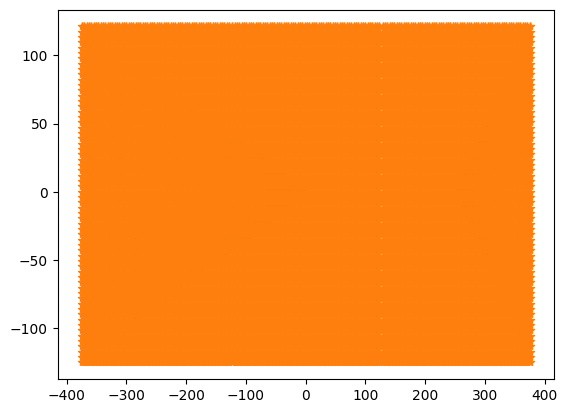

In [ ]:
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'*');

**Check gradient 0th moments over one TR**

In [ ]:
# Excitation events are filled with NaN in k_traj, find trajectory before second NaN
# Note: Because this is one sample before the excitation, if a gradient is enabled, the moment calculation will be off by the area of one sample (amplitude * grad_raster_time)!
end_of_tr_inds = np.flatnonzero(np.isnan(k_traj[0])) - 1
k_traj_after_first_tr = k_traj[:, end_of_tr_inds[1]]

print(f'X moment: {k_traj_after_first_tr[0]: 8.2f}/m   {k_traj_after_first_tr[0]/(Nx*delta_kx): 8.2f} cycles/voxel')
print(f'Y moment: {k_traj_after_first_tr[1]: 8.2f}/m   {k_traj_after_first_tr[1]/(Ny*delta_ky): 8.2f} cycles/voxel')
print(f'Z moment: {k_traj_after_first_tr[2]: 8.2f}/m   {k_traj_after_first_tr[2]/(Nz*delta_kz): 8.2f} cycles/voxel')

X moment:   251.56/m       1.01 cycles/voxel
Y moment:     0.00/m       0.00 cycles/voxel
Z moment:    -0.53/m      -0.00 cycles/voxel


**Animate trajectory**

In [ ]:
ani = animate(seq, show=False, dt=seq.duration()[0] / 10, plot_window=seq.duration()[0], fps=10, show_progress=True)
from IPython.display import HTML
HTML(ani.to_html5_video())

  0%|          | 0/10 [00:00<?, ?it/s]

**Run MR-zero simulation**

The code below simulates the whole sequence, and shows the magnitude of the raw k-space profiles in acquisition order.

/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


Calculating repetition 84 / 84 - done


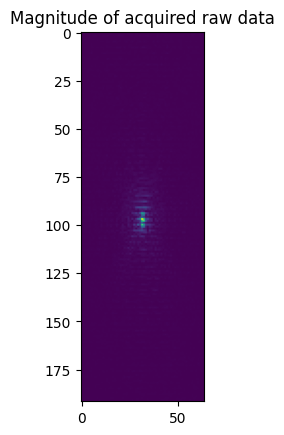

In [ ]:
# Simulate sequence
kdata = simulate_2d(seq, sim_size=[128,128], noise_level=0.5, n_coils=1, B0_scale=1)

# Display raw data profiles
plt.figure()
plt.imshow(abs(kdata[0]))
plt.title('Magnitude of acquired raw data');

**Reconstruct simulated data**

Detected labels in the sequence!
Automatically detected matrix size: ['ECO', 'SLC', 'LIN', 'ADC'] [3, 1, 64, 64]


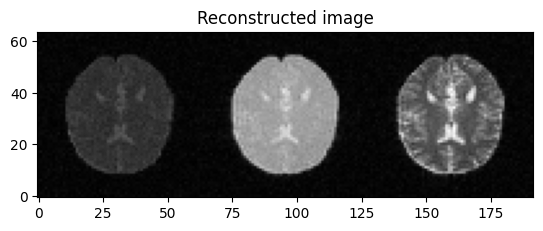

In [ ]:
rec = recon_cartesian_3d(kdata, seq)

plot_nd(rec)
plt.title('Reconstructed image');